In [25]:
pwd = "/Users/youtao/code"
hdf5_data_path = '/scratch/ty296/hdf5_data/'
groupname = 'L'
p_fixed_name = 'p_ctrl'
p_fixed_value = 0.4
import os
print(os.getcwd())
import sys
sys.path.append('/scratch/ty296/CT_MPS_mini')
import h5py
import numpy as np

/Users/youtao/code/CT_MPS_mini


In [26]:
# View singular values from your HDF5 file
filename = os.path.join(pwd, "hdf5_data_combined/sv_combined_p_ctrl0.0.h5")
real_num = 0
with h5py.File(filename, 'r') as f:
    # Get the first key to examine
    first_key = list(f.keys())[real_num]
    print(f"Examining key: {first_key}")
    
    # Get the singular values array
    sv_array = f[first_key][()]
    
    # Display basic info
    print(f"Shape: {sv_array.shape}")
    print(f"Data type: {sv_array.dtype}")
    print(f"Number of singular values: {len(sv_array)}")
    
    # Display the actual values
    print(f"\nSingular values:")
    print(sv_array)
    
    # Display metadata
    print(f"\nMetadata:")
    for attr_name, attr_value in f[first_key].attrs.items():
        print(f"  {attr_name}: {attr_value}")


Examining key: real1
Shape: (50,)
Data type: float64
Number of singular values: 50

Singular values:
[0.20201875 0.19171947 0.18788527 0.18067555 0.17618726 0.17150382
 0.1667154  0.16356708 0.15805365 0.15684329 0.1503494  0.14789525
 0.14464864 0.14089605 0.13801743 0.1346994  0.13208157 0.12706832
 0.12243249 0.11956613 0.11832671 0.11411028 0.11327885 0.10814257
 0.10678324 0.1037082  0.10080789 0.09771678 0.09508722 0.09019108
 0.0893896  0.08566195 0.08272946 0.0811435  0.07728106 0.0733307
 0.07051863 0.06821181 0.06528915 0.06286599 0.06044445 0.05845448
 0.05650776 0.05184202 0.04880666 0.04636552 0.043559   0.04094253
 0.03785486 0.03726371]

Metadata:
  L: 12
  maxbond: 50
  maxdim: 50
  n_chunk_realizations: 10
  p_ctrl: 0.0
  p_proj: 0.0


In [28]:
with h5py.File(filename, 'r') as f:
    L_target = 24
    matching_groups = []
    
    print(f"Searching for groups with L={L_target}...")
    print("=" * 80)
    
    # Loop through all realizations
    for key in f.keys():
        # Check if this group has L=24
        if 'L' in f[key].attrs and f[key].attrs['L'] == L_target:
            matching_groups.append(key)
    
    print(f"Found {len(matching_groups)} groups with L={L_target}")
    print()
    
    # # Display information for each matching group
    # for i, key in enumerate(matching_groups):
    #     sv_array = f[key][()]
    #     attrs = dict(f[key].attrs)
        
    #     print(f"Group {i+1}: {key}")
    #     print(f"  L = {attrs.get('L')}")
    #     print(f"  p_ctrl = {attrs.get('p_ctrl')}")
    #     print(f"  p_proj = {attrs.get('p_proj')}")
    #     print(f"  maxbond = {attrs.get('maxbond')}")
    #     print(f"  Singular value array shape: {sv_array.shape}")
    #     print(f"  Singular values: {sv_array}")
    #     print(f"  Max SV: {np.max(sv_array):.6e}")
    #     print(f"  Min SV: {np.min(sv_array):.6e}")
    #     print(f"  Number of SVs: {len(sv_array)}")
    #     print("-" * 60)


Searching for groups with L=24...
Found 200 groups with L=24



In [29]:
# Plot singular values for all L=24 groups
L24_groups = []

with h5py.File(filename, 'r') as f:
    L_target = 20
    
    # Collect all L=24 groups
    for key in f.keys():
        if 'L' in f[key].attrs and f[key].attrs['L'] == L_target:
            L24_groups.append(key)


In [30]:
for key in L24_groups[:5]:
    with h5py.File(filename, 'r') as f:
        print(f[key].attrs.keys())
        print(f[key].attrs['p_proj'])


<KeysViewHDF5 ['L', 'maxbond', 'maxdim', 'n_chunk_realizations', 'p_ctrl', 'p_proj']>
0.47368421052631576
<KeysViewHDF5 ['L', 'maxbond', 'maxdim', 'n_chunk_realizations', 'p_ctrl', 'p_proj']>
0.42105263157894735
<KeysViewHDF5 ['L', 'maxbond', 'maxdim', 'n_chunk_realizations', 'p_ctrl', 'p_proj']>
0.631578947368421
<KeysViewHDF5 ['L', 'maxbond', 'maxdim', 'n_chunk_realizations', 'p_ctrl', 'p_proj']>
0.631578947368421
<KeysViewHDF5 ['L', 'maxbond', 'maxdim', 'n_chunk_realizations', 'p_ctrl', 'p_proj']>
0.05263157894736842


In [31]:
from read_hdf5_func import von_neumann_entropy_sv
dict = {}
with h5py.File(filename, 'r') as f:
    for key in L24_groups:
        entropy = von_neumann_entropy_sv(f[key][()], n=0, positivedefinite=False, threshold=1e-15)
        p_proj = f[key].attrs['p_proj']
        if p_proj in dict:
            dict[p_proj].append(entropy)
        else:
            dict[p_proj] = [entropy]
        # print(entropy)
        # print(f[key].attrs['p_proj'])

In [32]:
print(len(dict))

20


2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000


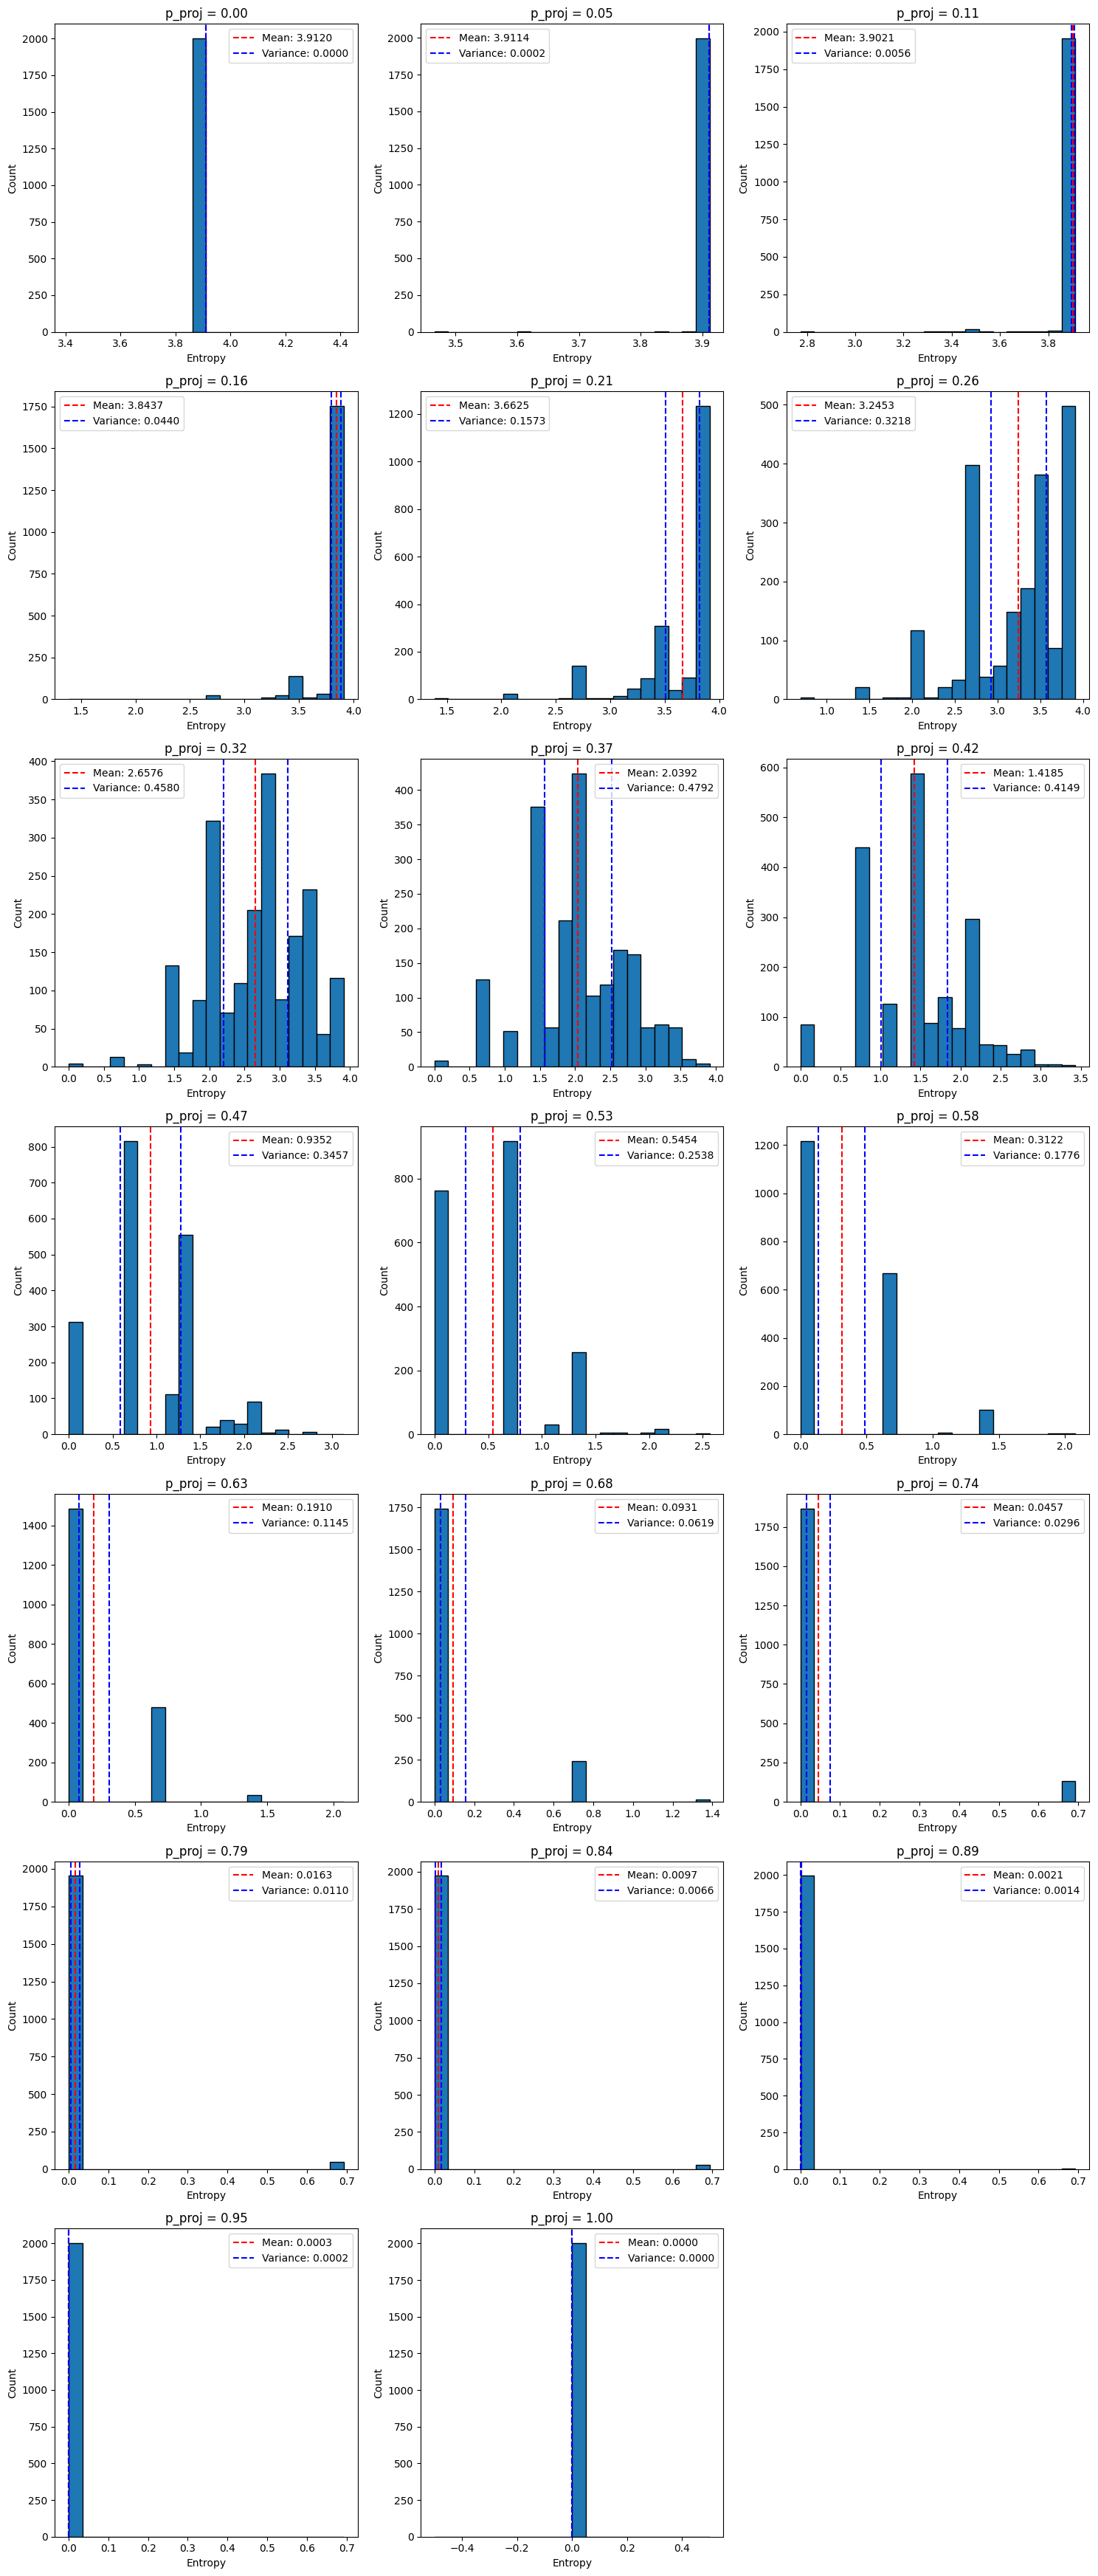

In [33]:
import matplotlib.pyplot as plt
from read_hdf5_func import calculate_variance_and_error, calculate_mean_and_error

# Create a figure with subplots arranged based on number of p_proj values
n_plots = len(dict)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

# Plot histogram for each p_proj value
for idx, (p_proj, entropies) in enumerate(sorted(dict.items())):
    ax = axes[idx]
    mean, sem = calculate_mean_and_error(entropies)
    var, semvar = calculate_variance_and_error(entropies)
    print(len(entropies))
    ax.hist(entropies, bins=20, edgecolor='black')
    ax.set_title(f'p_proj = {p_proj:.2f}')
    ax.set_xlabel('Entropy')
    ax.set_ylabel('Count')
    ax.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.4f}')
    ax.axvline(mean + var, color='blue', linestyle='--', label=f'Variance: {var:.4f}')
    ax.axvline(mean - var, color='blue', linestyle='--')
    ax.legend()

# Remove any empty subplots
for idx in range(len(dict), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


In [34]:
dict_maxbond = {}
with h5py.File(filename, 'r') as f:
    for key in L24_groups:
        maxbond = f[key].attrs['maxbond']
        p_proj = f[key].attrs['p_proj']
        if p_proj in dict_maxbond:
            dict_maxbond[p_proj].append(maxbond)
        else:
            dict_maxbond[p_proj] = [maxbond]
        # print(entropy)
        # print(f[key].attrs['p_proj'])

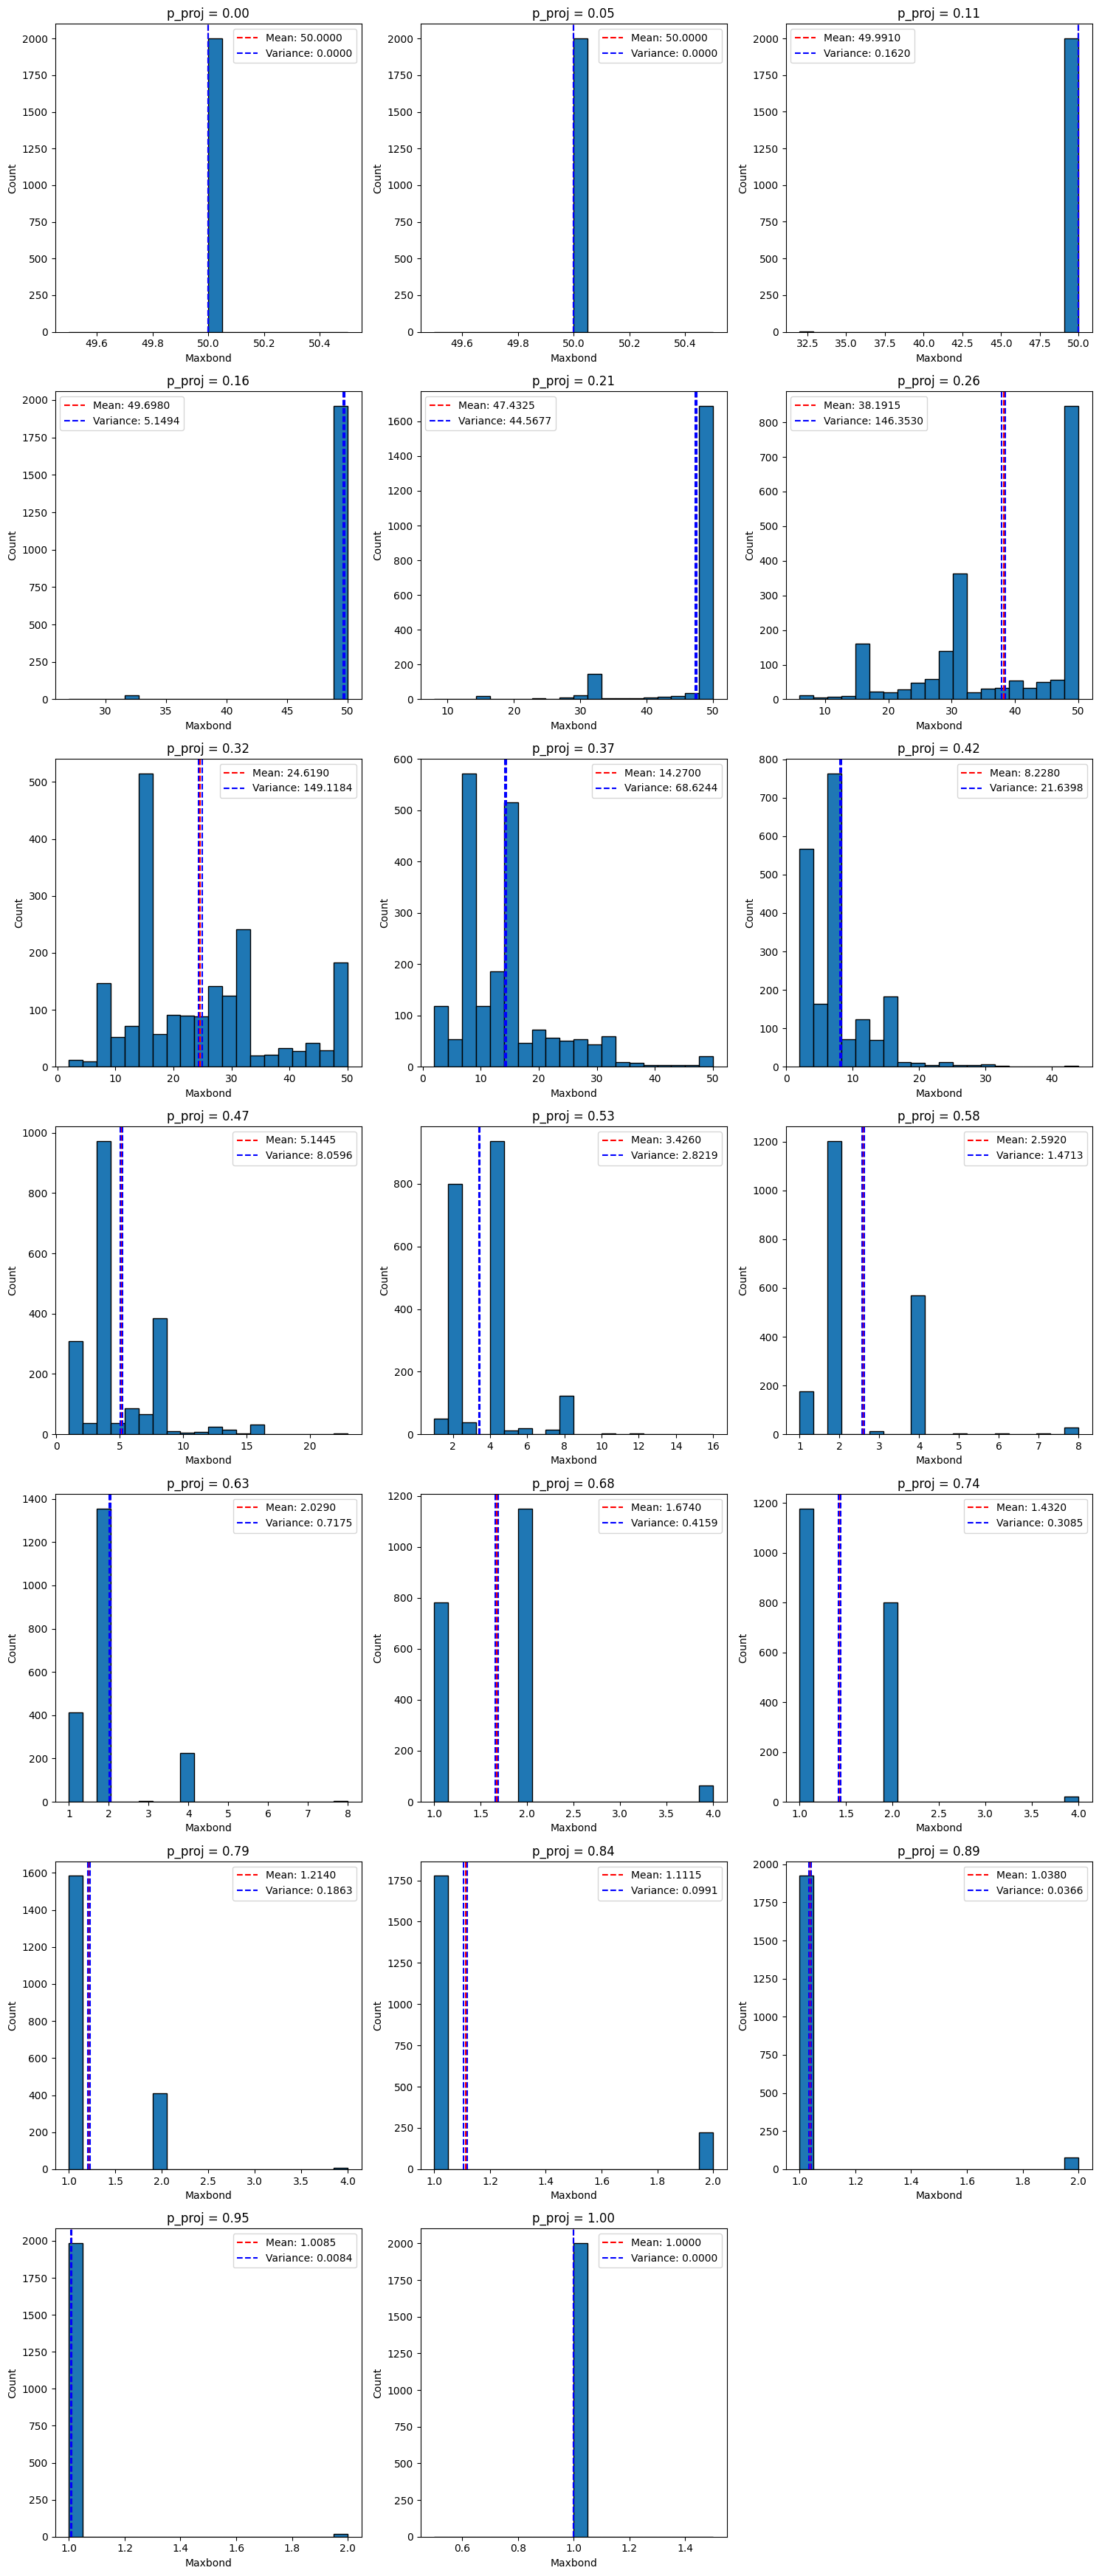

In [35]:
import matplotlib.pyplot as plt
from read_hdf5_func import calculate_variance_and_error, calculate_mean_and_error

# Create a figure with subplots arranged based on number of p_proj values
n_plots = len(dict_maxbond)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

# Plot histogram for each p_proj value
for idx, (p_proj, maxbonds) in enumerate(sorted(dict_maxbond.items())):
    ax = axes[idx]
    mean, sem = calculate_mean_and_error(maxbonds)
    var, semvar = calculate_variance_and_error(maxbonds)
    # print(maxbonds)
    ax.hist(maxbonds, bins=20, edgecolor='black')
    ax.set_title(f'p_proj = {p_proj:.2f}')
    ax.set_xlabel('Maxbond')
    ax.set_ylabel('Count')
    ax.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.4f}')
    ax.axvline(mean + sem, color='blue', linestyle='--', label=f'Variance: {var:.4f}')
    ax.axvline(mean - sem, color='blue', linestyle='--')
    ax.legend()

# Remove any empty subplots
for idx in range(len(dict), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


In [36]:
print(list(dict_maxbond.keys()))
key = list(dict_maxbond.keys())

print(key)
print(dict_maxbond[key])

[0.47368421052631576, 0.42105263157894735, 0.631578947368421, 0.05263157894736842, 0.6842105263157895, 0.7368421052631579, 0.7894736842105263, 0.8421052631578947, 0.8947368421052632, 0.9473684210526315, 0.0, 1.0, 0.10526315789473684, 0.15789473684210525, 0.21052631578947367, 0.2631578947368421, 0.3157894736842105, 0.3684210526315789, 0.5263157894736842, 0.5789473684210527]
[0.47368421052631576, 0.42105263157894735, 0.631578947368421, 0.05263157894736842, 0.6842105263157895, 0.7368421052631579, 0.7894736842105263, 0.8421052631578947, 0.8947368421052632, 0.9473684210526315, 0.0, 1.0, 0.10526315789473684, 0.15789473684210525, 0.21052631578947367, 0.2631578947368421, 0.3157894736842105, 0.3684210526315789, 0.5263157894736842, 0.5789473684210527]


TypeError: unhashable type: 'list'

In [ ]:
len(L24_groups)